## Demo: Assesing hijacking of GCG suffixes

### Setup

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"  # 'html'
pio.templates.default = "plotly_white"

In [6]:
# TODO remove:
import os
import sys
os.getcwd()
project_dir = '/home/sharifm/students/matanbentov/interp-jailbreak-dev/'
os.chdir(project_dir)

# os.environ["HF_HOME"] = "/home/sharifm/students/matanbentov"  # modify to home defaco dir

# Add the project directory to the sys.path to ensure Python imports from there
sys.path.append(project_dir)

from src.interp.utils import load_model
from src.evaluate.utils import load_data

In [ ]:
model_name = "google/gemma-2-2b-it"
# model_name = "qwen/qwen2.5-1.5b-instruct"
# model_name = "meta-llama/llama-3-8b-instruct"


data_df = load_data(model_name=model_name)

model = load_model(model_name)

### EDAing the GCG dataset

In [ ]:
print(f">> dataset size: {data_df.shape[0]} rows.")
print(f">> {data_df.suffix_id.nunique()} different GCG suffixes, evaluated on {data_df.message_id.nunique()} messages.")

univ_scores = data_df.groupby('suffix_id').agg({'univ_score': 'first'}).sort_values(by='univ_score', ascending=False).reset_index()
# TODO fix
# px.bar(
#     univ_scores,
#     x='univ_score',
#     title=f"GCG suffixes' Universal Scores ({model_name})",
#     labels={'universal_score': 'Universal Score'},
# ).show()

### Transformed Vectors Analysis

In [ ]:
# TODO demonstrate fork usage

### Dominance score

Quantifying the dominance score across the layers (reproducing Fig. 5 in the paper).

In [ ]:
def show_dominance_area_plot(dom_scores, name=None):
    ## build df:
    df = []
    for src_name, values in dom_scores.items():
        for layer, val in enumerate(values):
            df.append({
                'src_name': src_name,
                'layer': layer,
                'val': val.item()
            })
    df = pd.DataFrame(df)

    colors = {
        'bos': '#A9A9A9',       # Dark grey
        'chat_pre': '#D3D3D3',  # Light grey
        'instr': '#4B77BE',     # Dark green
        'adv': "#E8362D",           # Dark red
        'chat[:-1]': '#FFA500',      # Orange
        'chat[-1]': '#FFB84D'       # Light orange-yellow (subtler)
    }

    px.area(
        df,
        x='layer',
        y='val',
        color='src_name',
        labels={'val': 'Dominance Score', 'layer': 'Layer', 'src_name': 'Source Subseq.'},
        color_discrete_map=colors,
        width=500, height=350,
        template='plotly_white',
        title=f"Dominance Scores to 'chat[-1]'" + (f' ({name})' if name else ''),
    ).show()

In [ ]:
# from src.interp.dominance_tools import get_adv_hijack_score
import src.interp.dominance_tools as dominance_tools
from importlib import reload
reload(dominance_tools)

message = data_df[data_df.message_id == 619].iloc[0].message_str
suffix_rand = data_df[data_df.suffix_category == 'init'].suffix_str.iloc[0]
suffix_gcg = data_df[data_df.suffix_rank == 0].suffix_str.iloc[0]

for suffix_name, suffix_str in [('random suffix', suffix_rand), ('GCG suffix', suffix_gcg)]:
    dom_scores = dominance_tools.get_dom_scores(
        model,
        message, suffix_str,
        dst_slc_name = 'chat[-1]',
        hijacking_metric ='Y@attn',  # 'Y@resid', 'Y@attn', 'X@WVO@attn', 'Y@dcmp_resid', 'Y@dir
        hijacking_metric_flavor = 'sum',  # 'sum', 'sum-top0.1'
    )

    show_dominance_area_plot(dom_scores, name=suffix_name)

In [ ]:
from src.interp.utils import get_idx_slices


get_idx_slices(
        model, message, suffix_str, response_str="", 
    )

### Hijacking vs Universality

# TODO move to script

Comparing suffixes' universality to their hijacking (repeating analysis in Fig. 8, in small scale).

In [ ]:
import random
import numpy as np

# TODO scale!

random.seed(42)
message_ids = random.sample(data_df.message_id.unique().tolist(), 10)
suffix_ids = []
intervals = [0, 0.01, 0.025] + np.arange(0.05, data_df.univ_score.max(), 0.10).tolist()
for i in range(len(intervals) - 1):
    interval = (intervals[i], intervals[i + 1])
    suffixes_in_interval =  data_df[data_df.univ_score.between(*interval)].suffix_id.unique().tolist()
    suffix_ids.extend(random.sample(
       suffixes_in_interval, min(10, len(suffixes_in_interval))
    ))

print(f"{len(message_ids)=}, {len(suffix_ids)=}")

In [ ]:
from tqdm.contrib.itertools import product
import src.interp.dominance_tools as dominance_tools

df = []

for message_id, suffix_id in product(message_ids, suffix_ids):
    message_str = data_df[data_df.message_id == message_id].iloc[0].message_str
    suffix_row = data_df[data_df.suffix_id == suffix_id].iloc[0]
    suffix_str, suffix_univ, suffix_id = suffix_row.suffix_str, suffix_row.univ_score, suffix_row.suffix_id

    dom_scores = dominance_tools.get_dom_scores(
        model,
        message_str, suffix_str,
        dst_slc_name = 'chat[-1]',
        hijacking_metric ='Y@attn',
        hijacking_metric_flavor = 'sum',
    )
    hijacking_strength = dom_scores['adv'][20].item()  # adv's dominance score at layer 20 (for Gemma-2-2b-it)

    df.append({
        'message_id': message_id,
        'suffix_id': suffix_id,
        'message_str': message_str,
        'suffix_str': suffix_str,
        'suffix_univ': suffix_univ,
        'hijacking_strength': hijacking_strength  # TODO make this dom_adv_score
    })

df = pd.DataFrame(df)

In [7]:
# df.to_csv('tmp_gemma-2-2b-it-hijacking-strength.csv', index=False)
df = pd.read_csv('results/grid_hijacking_google_gemma-2-2b-it.csv')
df = df[(df.src == 'adv') & (df.layer == 20)].reset_index(drop=True)
df.head()

,message_id,suffix_id,suffix_univ,src,layer,dom_score
0,709,"161__mid0_[0.1,0.5]",0.005987,adv,20,0.343240
1,709,"34__mid0_[0.5,1]",0.004885,adv,20,0.375663
2,709,"27__mid0_[0.5,1]",0.005605,adv,20,0.247958
3,709,"11__mid0_[0.1,0.5]",0.006485,adv,20,0.179915
4,709,"107__mid0_[0.1,0.5]",0.008900,adv,20,0.073223


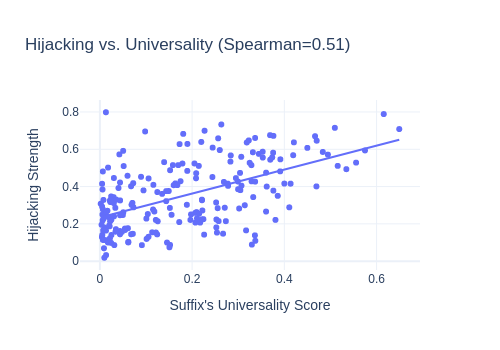

In [8]:
from scipy.stats import spearmanr
agg_df = df[['suffix_id', 'suffix_univ', 'dom_score']].groupby('suffix_id').mean().reset_index()  # TODO after avg call it (=the adv dom) hijacking_strength
spearman_corr, _ = spearmanr(agg_df['suffix_univ'], agg_df['dom_score'])

px.scatter(
    agg_df,
    # df,
    # color='suffix_id',
    x='suffix_univ',
    y='dom_score',
    labels={'suffix_univ': "Suffix's Universality Score", 'dom_score': 'Hijacking Strength'},
    title=f'Hijacking vs. Universality (Spearman={spearman_corr:.2f})',
    width=500, height=350,
    trendline="ols",
    # log_x=True,
)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np


# Bin the universality scores
bins = intervals
bins = [0, 0.01/2, 0.01, 0.05] + np.arange(0.11, data_df.univ_score.max(), 0.10).tolist() + [data_df.univ_score.max()]
labels = [f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(bins)-1)]
agg_df["univ_bin"] = pd.cut(agg_df["suffix_univ"], bins=bins, labels=labels, include_lowest=True)
agg_df.sort_values(by="univ_bin", inplace=True)

# Compute means per bin
trend_df = agg_df.groupby("univ_bin", observed=True)["dom_score"].median().reset_index()

# Plot boxplot using PX
fig = px.box(
    agg_df, x="univ_bin", y="dom_score", points="outliers",
    labels={
        "univ_bin": "Universality Score",
        "dom_score": "Hijacking Strength"
    },
    width=500, height=350,
    color_discrete_sequence=["cornflowerblue"]
)

# Add trendline over medians
fig.add_trace(go.Scatter(
    x=trend_df["univ_bin"],
    y=trend_df["dom_score"],
    mode="lines+markers",
    line=dict(color="crimson", width=3),
    marker=dict(size=6),
    name="Median Trend"
))

# Layout tweaks
fig.update_layout(
    xaxis_tickangle=45,
    showlegend=False,
)

# fig.show()


NameError: name 'intervals' is not defined